In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
# from ROI_extraction import preprocess_image
import cv2
import sys
sys.path.append("..")
from common_functions import image_data_generation

In [2]:
dataset_path = '../images/ROI_pollub/'
params = {'dim': (104,104),
          'batch_size': 64,
          'n_classes': 3,
          'n_channels': 3
        }
X,y_categorical,y = image_data_generation(dataset_path,params)

In [3]:
input_img = keras.Input(shape=(params['dim'][0], params['dim'][1],params['n_channels']))

# Encoder Layers
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder Layers
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
decoded = keras.layers.Conv2D(params['n_channels'], (3, 3), activation='sigmoid', padding='same')(x)

# Define the SSIM loss function
def ssim_loss(y_true, y_pred):
    ssim_value = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 1.0 - ssim_value

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss=ssim_loss)

# Train the autoencoder
history_loss = autoencoder.fit(x=X,y=X,epochs=40)
# Extract the deep features
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(X)
encoded_imgs = encoded_imgs.reshape(len(encoded_imgs), 13*13*8)

autoencoder.summary()

Epoch 1/40
157/157 [==============================] - 18s 90ms/step - loss: 0.1201
Epoch 2/40
157/157 [==============================] - 14s 89ms/step - loss: 0.0286
Epoch 3/40
157/157 [==============================] - 13s 86ms/step - loss: 0.0243
Epoch 4/40
157/157 [==============================] - 15s 93ms/step - loss: 0.0235
Epoch 5/40
157/157 [==============================] - 14s 88ms/step - loss: 0.0221
Epoch 6/40
157/157 [==============================] - 14s 87ms/step - loss: 0.0219
Epoch 7/40
157/157 [==============================] - 14s 90ms/step - loss: 0.0214
Epoch 8/40
157/157 [==============================] - 14s 90ms/step - loss: 0.0212
Epoch 9/40
157/157 [==============================] - 14s 88ms/step - loss: 0.0210
Epoch 10/40
157/157 [==============================] - 16s 102ms/step - loss: 0.0204
Epoch 11/40
157/157 [==============================] - 16s 103ms/step - loss: 0.0200
Epoch 12/40
157/157 [==============================] - 14s 90ms/step - loss: 0.0201

In [ ]:
decoded_imgs = autoencoder.predict(X)

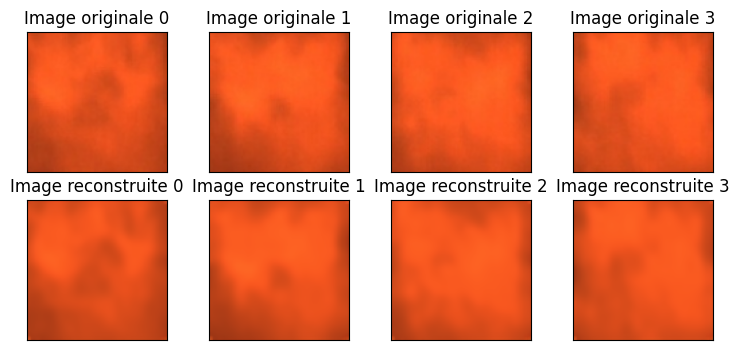

In [23]:

n = 4  # Number of images to display
plt.figure(figsize=(9, 4))
for i in range(n):
    # Display original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor(X[i], cv2.COLOR_RGB2BGR))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'Image originale {i}')

    # Display reconstructed image
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(cv2.cvtColor(decoded_imgs[i], cv2.COLOR_RGB2BGR))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'Image reconstruite {i}')
plt.show()

d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

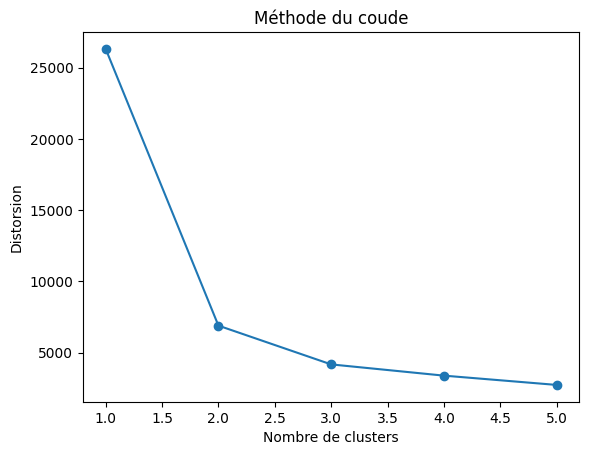

In [24]:
distortions = []
max_clusters = 5
for k in range(1, max_clusters+1):
    #train clustering algorithm
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(encoded_imgs)
    distortions.append(kmeans.inertia_)

# Tracer le graphique des distortions
plt.plot(range(1, max_clusters + 1), distortions, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Distorsion')
plt.title('Méthode du coude')
plt.show()


In [42]:
distortions

[52005.93359375,
 12214.314453125,
 7111.556640625,
 5852.3037109375,
 4722.80517578125]

d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

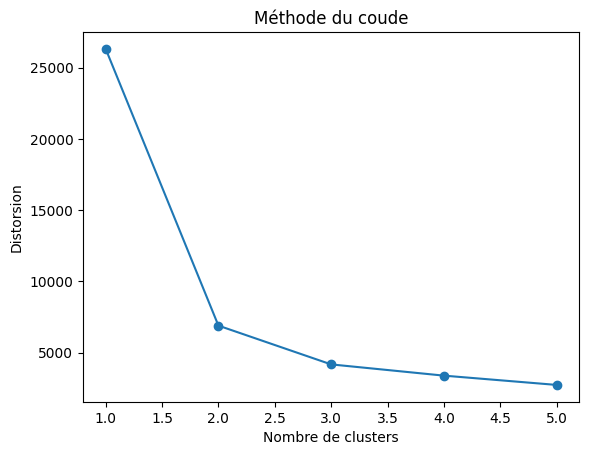

In [25]:
distortions = []
max_clusters = 5
for k in range(1, max_clusters+1):
    #train clustering algorithm
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(encoded_imgs)
    distortions.append(kmeans.inertia_)

# Tracer le graphique des distortions
plt.plot(range(1, max_clusters + 1), distortions, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Distorsion')
plt.title('Méthode du coude')
plt.show()

d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

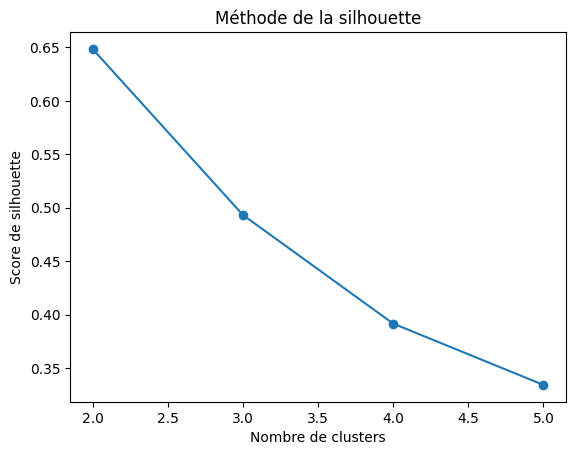

In [26]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(encoded_imgs)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(encoded_imgs, labels))

# Tracer le graphique des scores de silhouette
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.title('Méthode de la silhouette')
plt.show()

d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nrozo\AppData\Local\Temp\ipykernel_6888\46343738.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_transformed[kmeans.labels_ == i, 0],


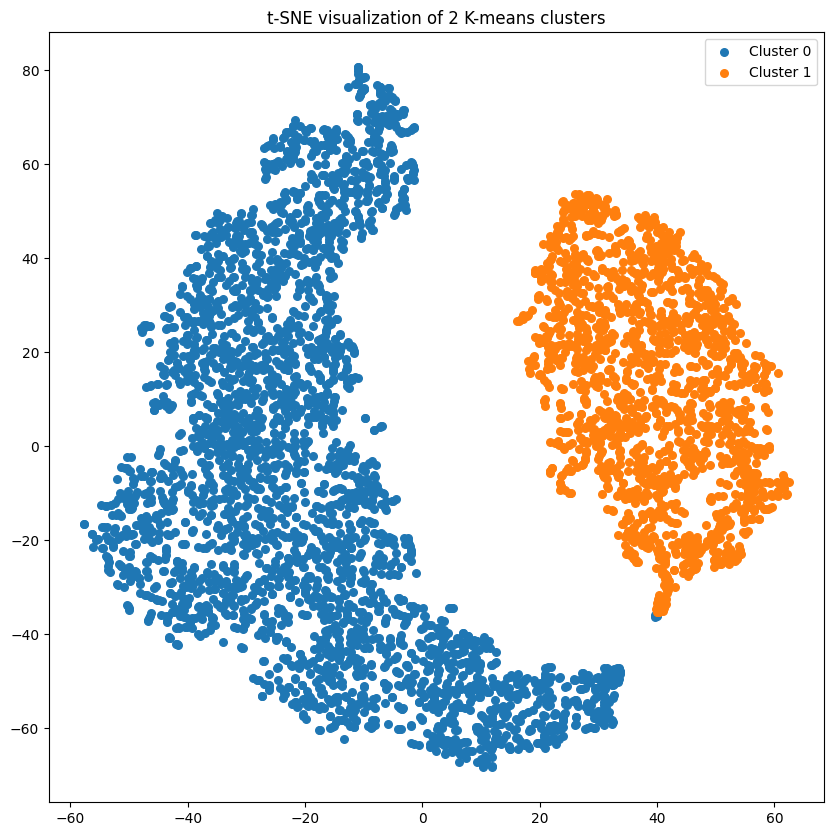

d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\nrozo\AppData\Local\Temp\ipykernel_6888\46343738.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_transformed[kmeans.labels_ == i, 0],


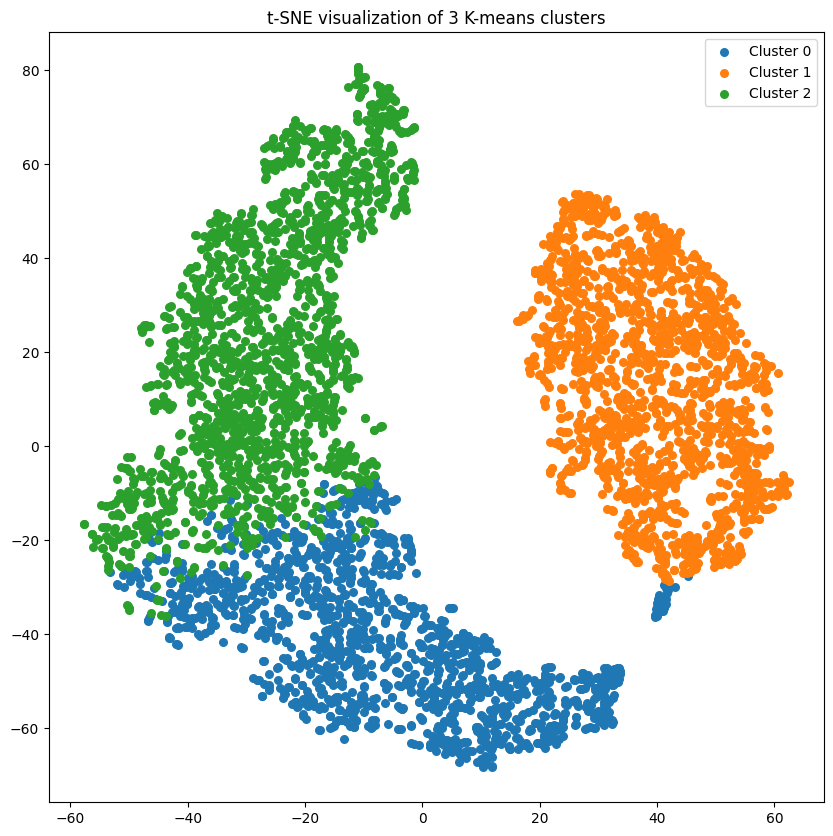

In [27]:
from sklearn.manifold import TSNE

def plot_clusters_tsne(n_clusters):
    # Use t-SNE to visualize the clusters
    tsne = TSNE(n_components=2, random_state=0)
    tsne_transformed = tsne.fit_transform(encoded_imgs)

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(encoded_imgs)

    # Plot the clusters
    plt.figure(figsize=(10, 10))
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    for i in range(n_clusters):
        plt.scatter(tsne_transformed[kmeans.labels_ == i, 0],
                    tsne_transformed[kmeans.labels_ == i, 1],
                    s=30, c=colors[i], label='Cluster %d' % i)
    plt.legend()
    plt.title(f"t-SNE visualization of {n_clusters} K-means clusters")
    plt.show()

plot_clusters_tsne(2)
plot_clusters_tsne(3)

d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

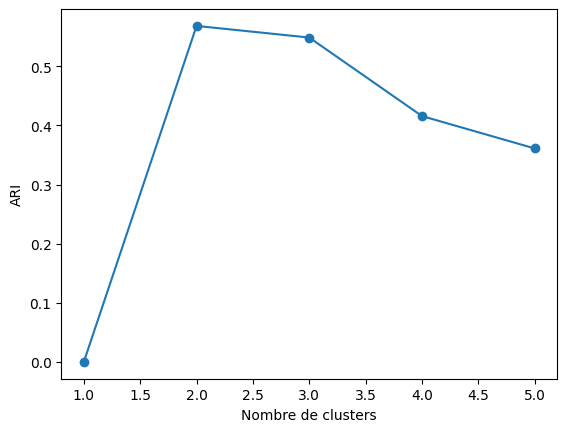

In [28]:
aris = []
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(encoded_imgs)
    y_pred = kmeans.labels_
    y_argmax= np.argmax(y_categorical, axis=-1)
    # Évaluer le clustering en utilisant l'index de Rand ajusté (ARI)
    aris.append(metrics.adjusted_rand_score(y_argmax, y_pred))

# Tracer le graphique des scores de silhouette
plt.plot(range(1, max_clusters + 1), aris, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('ARI')
plt.show()

C:\Users\nrozo\AppData\Local\Temp\ipykernel_6888\3318727939.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_transformed[y_argmax == i, 0],


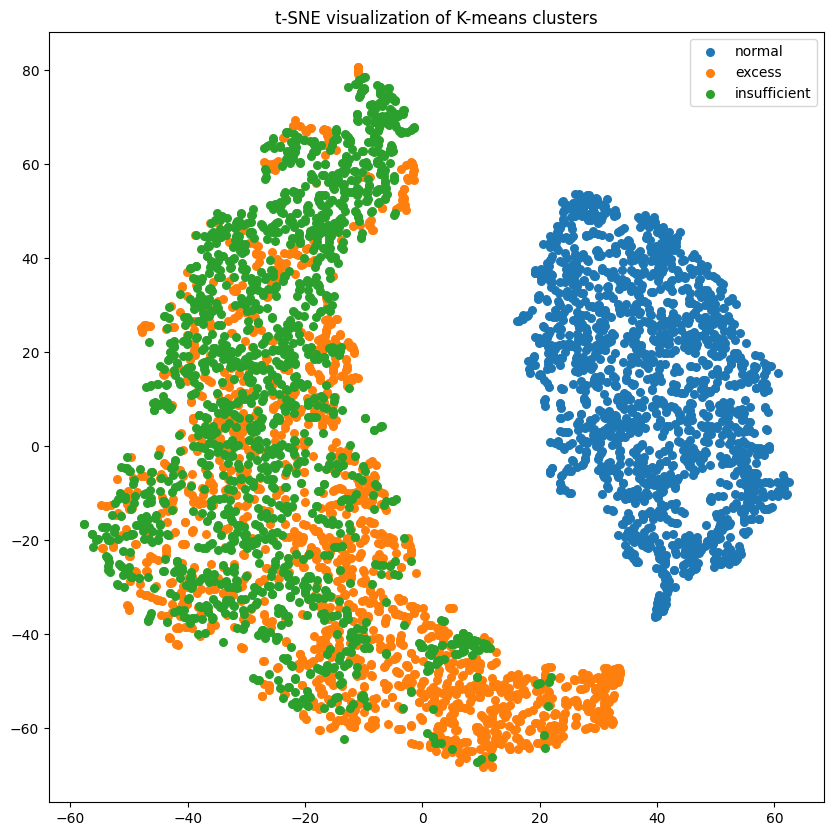

In [35]:
from sklearn.manifold import TSNE
# Use t-SNE to visualize the clusters
tsne = TSNE(n_components=2, random_state=0)
tsne_transformed = tsne.fit_transform(encoded_imgs)

classes={0:'normal',1:'excess',2:'insufficient'}

# Plot the clusters
plt.figure(figsize=(10, 10))
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for i in range(3):
    plt.scatter(tsne_transformed[y_argmax == i, 0],
                tsne_transformed[y_argmax == i, 1],
                s=30, c=colors[i], label=f'{classes[i]}')
plt.legend()
plt.title('t-SNE visualization of K-means clusters')
plt.show()

In [ ]:
-1 is two